<a href="https://colab.research.google.com/github/juliusberner/regularity_relu_network/blob/master/fastai_custom_ReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

In [0]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
size = 64 #px
lr = 1e-3
bs = 4 #64

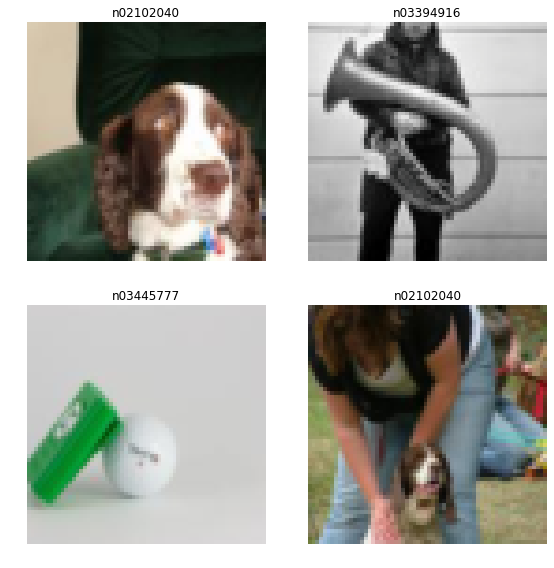

In [6]:
data = (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder()
            .transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=8)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))
data.show_batch()

In [7]:
#learn = (Learner(data, models.xresnet50(), metrics=[accuracy,top_k_accuracy], wd=1e-3, opt_func=optim.Adam,
         #bn_wd=False, true_wd=True, loss_func = LabelSmoothingCrossEntropy())
        #.mixup(alpha=0.2).to_fp16(dynamic=True))
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.7MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [0]:
class SaveGradInput():

    def __init__(self, m): 
        self.hook = m.register_backward_hook(self.hook_fn)
        self.input_grads=[]
        self.num_zeros=[]
    def hook_fn(self, module, grad_input, grad_output): 
        n = torch.nonzero(grad_input[0]==0).nelement()
        if n!=0:
            self.input_grads.append(grad_input[0])
        self.num_zeros.append(n)
    def close(self): self.hook.remove()

In [0]:
relu_modules = [module for module in learn.model.modules() if type(module) == nn.ReLU]
relu_hooks=[]
for relu in relu_modules:
    relu_hooks.append(SaveGradInput(relu))

In [10]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

In [0]:
for hook in relu_hooks:
    hook.close()

In [12]:
for i in range(18):
    print(len(relu_hooks[i].num_zeros))

401
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
1203
401
